# Figure 9

In [1]:
import os

# Load raw 
f_name = "../raw_data.csv"
OUT_FOLDER = "TMP_FOLDER/"
PLOTS_FOLDER = "PLOTS/"

if not os.path.exists(OUT_FOLDER):
   os.makedirs(OUT_FOLDER)

if not os.path.exists(PLOTS_FOLDER):
   os.makedirs(PLOTS_FOLDER)

DATA = []

with open(f_name, "r") as fp:
    
    # Get the field names from the first line of the csv
    headers = fp.readline().replace("\n", "").split("\t")
    print("Available fields:", headers) 
    
    # Loop through all lines of the csv file to load the raw data
    for l in fp:
        r = {} # row
        d = l.replace("\n", "").split("\t") # cleanup step
        for k, v in zip(headers, d): # Join headers with data
            r[k] = v
        
        DATA.append(r)
        
print("Total number of rows: {}".format(len(DATA)))
DATA[0]

Available fields: ['Timestamp', 'FirstPartyDomain', 'Country', 'RequestedDomain', 'ReferrerDomain', 'RequestType', 'ServerIP']
Total number of rows: 3413570


{'Timestamp': '1505229096',
 'FirstPartyDomain': 'ant1iwo.com',
 'Country': 'Cyprus',
 'RequestedDomain': 'tpc.googlesyndication.com',
 'ReferrerDomain': 'bs.serving-sys.com',
 'RequestType': 'script',
 'ServerIP': '82.199.68.72'}

In [2]:
CONT_MAP = {}

with open("Countries-Continents.csv", "r") as fp:
    for l in fp.readlines():
        tmp = l.strip().split(",")
        CONT_MAP[tmp[1]] = tmp[0]
        
print(len(CONT_MAP))

193


In [3]:
CONTINENTS = {}
NORM_COUNTRIES = {"United States": "US", "Russia": "Russian Federation", "Republic of Moldova": "Moldova"}
 
# Loop through all lines of the csv file
for l in DATA:
    country = l['Country']
    if country == "":
        continue
        
    if country in NORM_COUNTRIES:
        country = NORM_COUNTRIES[country]

    continent = None
    if country in CONT_MAP:
        continent = CONT_MAP[country]
    else: 
        print("{} does not existing in our mapping".format(country))
        ()+1

    if continent is not None and continent not in CONTINENTS:
        CONTINENTS[continent] = 0
        
    CONTINENTS[continent] += 1
    l['continent'] = continent
        
print(len(DATA))

3413570


In [4]:
print("Total number of Continents: {}".format(len(CONTINENTS)))
S_CONTINENTS = sorted(CONTINENTS.items(), key=lambda item: item[1], reverse=True)

for t in S_CONTINENTS:
    print("{}: {}".format(t[0], t[1]))

Total number of Continents: 5
Europe: 1916086
South America: 1064413
Asia: 199515
Africa: 171209
North America: 56219


In [5]:
import tldextract
from tqdm.notebook import tqdm

singles_found = set()
pairs_found = set()

perContinent = {}
perContinentPairs = {}

SHORT_CONT = {
    "North America": "N. America",
    "South America": "S. America"  
}

with tqdm(total=len(DATA), desc="Pages done") as pbar:
    
    for e in DATA:
        
        if "continent" not in e:
            pbar.update(1)
            continue

        continent = e['continent']
        if continent in SHORT_CONT:
            continent = SHORT_CONT[continent]

        if continent not in perContinent:
            perContinent[continent] = set()
            perContinentPairs[continent] = set()

        referrer_d = tldextract.extract(e["ReferrerDomain"]).registered_domain
        request_d = tldextract.extract(e["RequestedDomain"]).registered_domain

        reverse = request_d + "<->" + referrer_d
        correct = referrer_d + "<->" + request_d
                    
        if correct not in pairs_found and reverse not in pairs_found:
            pairs_found.add(correct)
                    
        if correct not in perContinentPairs[continent] and reverse not in perContinentPairs[continent]:
            perContinentPairs[continent].add(correct)
                    
        singles_found.add(referrer_d)
        singles_found.add(request_d)

        perContinent[continent].add(referrer_d)
        perContinent[continent].add(request_d)
                    
        pbar.update(1)

Pages done:   0%|          | 0/3413570 [00:00<?, ?it/s]

In [6]:
total_found = len(singles_found)
print("Single found: {}".format(total_found))
print("Total pairs found: {}".format(len(pairs_found)))
print("perContinent: {}".format(len(perContinent)))
print("perContinentPairs: {}".format(len(perContinentPairs)))

Single found: 1852
Total pairs found: 10644
perContinent: 5
perContinentPairs: 5


In [7]:
# perContinent
import pandas as pd

data_n = []

keyY = []
for i in perContinent:
    keyY.append("{} ({})".format(i, len(perContinent[i]) ))
    tmp = []
    keyX = []
    for j in perContinent:
        keyX.append(j)
        per = len(perContinent[i].intersection(perContinent[j])) / min([len(perContinent[i]),len(perContinent[j])])
        print("{}: {} - {}: {} ==> {} Inter: {} - Intersect: {:.2f}%".format(
            i, 
            len(perContinent[i]), 
            j, 
            len(perContinent[j]), 
            len(perContinent[i] - perContinent[j]), 
            len(perContinent[i].intersection(perContinent[j])),
            per
            )
        )
        tmp.append(per)
    line = {}
    for k, v in zip(keyX, tmp):
        line[k] = v
    data_n.append(line)

df_nodes = pd.DataFrame(data_n, index=keyY, columns=keyX)
df_nodes


Europe: 1533 - Europe: 1533 ==> 0 Inter: 1533 - Intersect: 1.00%
Europe: 1533 - N. America: 544 ==> 1022 Inter: 511 - Intersect: 0.94%
Europe: 1533 - S. America: 1106 ==> 608 Inter: 925 - Intersect: 0.84%
Europe: 1533 - Asia: 774 ==> 879 Inter: 654 - Intersect: 0.84%
Europe: 1533 - Africa: 632 ==> 948 Inter: 585 - Intersect: 0.93%
N. America: 544 - Europe: 1533 ==> 33 Inter: 511 - Intersect: 0.94%
N. America: 544 - N. America: 544 ==> 0 Inter: 544 - Intersect: 1.00%
N. America: 544 - S. America: 1106 ==> 80 Inter: 464 - Intersect: 0.85%
N. America: 544 - Asia: 774 ==> 159 Inter: 385 - Intersect: 0.71%
N. America: 544 - Africa: 632 ==> 173 Inter: 371 - Intersect: 0.68%
S. America: 1106 - Europe: 1533 ==> 181 Inter: 925 - Intersect: 0.84%
S. America: 1106 - N. America: 544 ==> 642 Inter: 464 - Intersect: 0.85%
S. America: 1106 - S. America: 1106 ==> 0 Inter: 1106 - Intersect: 1.00%
S. America: 1106 - Asia: 774 ==> 511 Inter: 595 - Intersect: 0.77%
S. America: 1106 - Africa: 632 ==> 556 I

,Europe,N. America,S. America,Asia,Africa
Europe (1533),1.000000,0.939338,0.836347,0.844961,0.925633
N. America (544),0.939338,1.000000,0.852941,0.707721,0.681985
S. America (1106),0.836347,0.852941,1.000000,0.768734,0.870253
Asia (774),0.844961,0.707721,0.768734,1.000000,0.748418
Africa (632),0.925633,0.681985,0.870253,0.748418,1.000000


In [8]:
# perContinentPairs
import pandas as pd

data_l = []

keyY = []
for i in perContinentPairs:
    keyY.append("{} ({})".format(i, len(perContinentPairs[i]) ))
    tmp = []
    keyX = []
    for j in perContinentPairs:
        keyX.append(j)
        per = len(perContinentPairs[i].intersection(perContinentPairs[j])) / min([len(perContinentPairs[i]),len(perContinentPairs[j])])
        print("{}: {} - {}: {} ==> {} Inter: {} - Intersect: {:.2f}%".format(
            i, 
            len(perContinentPairs[i]), 
            j, 
            len(perContinentPairs[j]), 
            len(perContinentPairs[i] - perContinentPairs[j]), 
            len(perContinentPairs[i].intersection(perContinentPairs[j])),
            len(perContinentPairs[i].intersection(perContinentPairs[j])) / len(perContinentPairs[i])
            )
        )
        tmp.append(per)
    line = {}
    for k, v in zip(keyX, tmp):
        line[k] = v
    data_l.append(line)

df_links = pd.DataFrame(data_l, index=keyY, columns=keyX)
df_links

Europe: 7673 - Europe: 7673 ==> 0 Inter: 7673 - Intersect: 1.00%
Europe: 7673 - N. America: 1405 ==> 6563 Inter: 1110 - Intersect: 0.14%
Europe: 7673 - S. America: 4726 ==> 4945 Inter: 2728 - Intersect: 0.36%
Europe: 7673 - Asia: 2461 ==> 6090 Inter: 1583 - Intersect: 0.21%
Europe: 7673 - Africa: 1896 ==> 6226 Inter: 1447 - Intersect: 0.19%
N. America: 1405 - Europe: 7673 ==> 295 Inter: 1110 - Intersect: 0.79%
N. America: 1405 - N. America: 1405 ==> 0 Inter: 1405 - Intersect: 1.00%
N. America: 1405 - S. America: 4726 ==> 425 Inter: 980 - Intersect: 0.70%
N. America: 1405 - Asia: 2461 ==> 696 Inter: 709 - Intersect: 0.50%
N. America: 1405 - Africa: 1896 ==> 692 Inter: 713 - Intersect: 0.51%
S. America: 4726 - Europe: 7673 ==> 1998 Inter: 2728 - Intersect: 0.58%
S. America: 4726 - N. America: 1405 ==> 3746 Inter: 980 - Intersect: 0.21%
S. America: 4726 - S. America: 4726 ==> 0 Inter: 4726 - Intersect: 1.00%
S. America: 4726 - Asia: 2461 ==> 3296 Inter: 1430 - Intersect: 0.30%
S. America:

,Europe,N. America,S. America,Asia,Africa
Europe (7673),1.000000,0.790036,0.577232,0.643234,0.763186
N. America (1405),0.790036,1.000000,0.697509,0.504626,0.507473
S. America (4726),0.577232,0.697509,1.000000,0.581065,0.709916
Asia (2461),0.643234,0.504626,0.581065,1.000000,0.559072
Africa (1896),0.763186,0.507473,0.709916,0.559072,1.000000


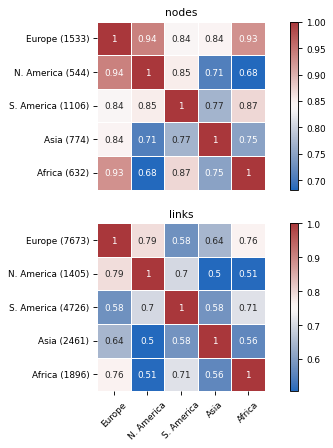

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn as sns

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 8}
matplotlib.rc('font', **font)

pp = PdfPages(PLOTS_FOLDER + "ContinentALLIntersectionPercentage.pdf")

fig, (ax,ax2) = plt.subplots(figsize=(4, 6), dpi=80, nrows=2)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(df_nodes, linewidth = 0.5, cmap = 'vlag', ax=ax, square=True, annot=True, cbar=False, xticklabels=False) #YlOrRd #coolwarm #vlag
ax.set_title("nodes")
ax.xaxis.set_tick_params(rotation=45)
fig.colorbar(ax.collections[0], ax=ax,location="right", use_gridspec=False, pad=0.1)

sns.heatmap(df_links, linewidth = 0.5, cmap = 'vlag', ax=ax2, square=True, annot=True, cbar=False)#, yticklabels=False)
ax2.set_title("links")
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.1)
ax2.yaxis.set_tick_params(rotation=0)
ax2.xaxis.set_tick_params(rotation=45)

#plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

# Figure 8

In [10]:
### Degree Distribution ###
import networkx as nx
import collections
edgeLists = {}

for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    #print(c, i)
    tmp = []
    edgeLists[i] = []
    for p in perContinentPairs[i]:
        t = p.split("<->")
        edgeLists[i].append("{} {}".format(t[0], t[1]))
        tmp.append(t)

    g = nx.from_edgelist(tmp)

    degree_sequence = sorted([d for n, d in g.degree()], reverse=False)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    aux_x, aux_y = zip(*degreeCount.items())
    n_nodes = len(degree_sequence) #g.number_of_nodes()
    lines = []
    for x, y in zip(aux_x, aux_y):
        if x == 1:
            lines.append("{} {}".format(x, 0.0))
        else:
            lines.append("{} {}".format(x, y/n_nodes))
            fi = i.replace(". ", "-")
    with open(OUT_FOLDER + "cont_{}_degree_distribution.txt".format(fi), "w") as fp:
        fp.write("\n".join(lines))

OLD_DATA = []
with open("../Datasets/EdgeList_TLD.txt", "r") as fp:
    for l in fp.readlines():
        OLD_DATA.append(l.strip().split(" "))

g = nx.from_edgelist(OLD_DATA)
degree_sequence = sorted([d for n, d in g.degree()], reverse=False)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
aux_x, aux_y = zip(*degreeCount.items())
n_nodes = len(degree_sequence) #g.number_of_nodes()
lines = []
for x, y in zip(aux_x, aux_y):
    if x == 1:
        lines.append("{} {}".format(x, 0.0))
    else:
        lines.append("{} {}".format(x, y/n_nodes))
with open(OUT_FOLDER + "cont_{}_degree_distribution.txt".format("TLD+1"), "w") as fp:
    fp.write("\n".join(lines))

for c in edgeLists:
    fc = c.replace(". ", "-")
    with open(OUT_FOLDER + "{}_edgeList.txt".format(fc), "w") as fp:
        fp.write("\n".join(edgeLists[c]))

## Steps for fortran log binning
For Windows users, see:  http://www.equation.com/servlet/equation.cmd?fa=fortran
1. compile from source (Windows): gfortran.exe -o P_k_binned .\P_k_binned.f
2. execute: .\P_k_binned.exe
3. input the source file: cont_S_America_degree_distribution.txt
4. input the initial position: 1.0
5. input the number of bins: 20

In [11]:
# Compile the fortran code from source
cmd = "gfortran.exe -o P_k_binned .\P_k_binned.f"
!{cmd}

In [12]:
# Create the file names of the output of the previous cell and generate the binning data using the .\P_k_binned.exe executable file
tmp = edgeLists.keys()
f_names = [x.replace(". ", "-") for x in tmp]
f_names.append("TLD+1")

init_val = 1.0
steps = 20

for f in f_names:
    input_file = OUT_FOLDER + "cont_{}_degree_distribution.txt".format(f)
    output_file = input_file.replace(".txt", ".dat")
    print(input_file)
    print(output_file)
    cmd = ".\P_k_binned.exe {} {} {} {}".format(input_file, output_file, init_val, steps)
    !{cmd}


TMP_FOLDER/cont_Europe_degree_distribution.txt
TMP_FOLDER/cont_Europe_degree_distribution.dat
 input_file:TMP_FOLDER/cont_Europe_degree_distribution.txt
 output_file:TMP_FOLDER/cont_Europe_degree_distribution.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         564
TMP_FOLDER/cont_N-America_degree_distribution.txt
TMP_FOLDER/cont_N-America_degree_distribution.dat
 input_file:TMP_FOLDER/cont_N-America_degree_distribution.txt
 output_file:TMP_FOLDER/cont_N-America_degree_distribution.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         137
TMP_FOLDER/cont_S-America_degree_distribution.txt
TMP_FOLDER/cont_S-America_degree_distribution.dat
 input_file:TMP_FOLDER/cont_S-America_degree_distribution.txt
 output_file:TMP_FOLDER/cont_S-America_degree_distribution.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         365
TMP_FOLDER/cont_Asia_degree_distribution.txt
TMP_FOLDER/cont_Asia_degree_distribution.dat
 input_file:TMP_FOLDER/cont_

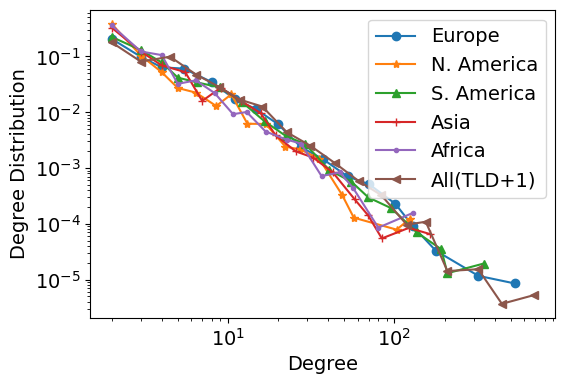

In [13]:
### Read the fortran output files and plot the results ###

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

pp = PdfPages(PLOTS_FOLDER + "ContinentDegreeDistribution.pdf")

plt.figure(figsize=(6, 4)) 
plt.xlabel('Degree')
plt.ylabel('Degree Distribution')
plt.xscale("log")
plt.yscale("log")

sympols = ["o-", "*-", "^-", "+-", ".-", "<-"]

for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    cont_name = i.replace(". ", "-")
    in_file_name = OUT_FOLDER + "cont_{}_degree_distribution.dat".format(cont_name)
    X = []
    Y = []
    with open(in_file_name, "r") as fp:
        for l in fp.readlines():
            tmp = l.strip().replace("D", "E").split(" ")
            X.append(float(tmp[0]))
            Y.append(float(tmp[1]))
    plt.plot(X, Y, sympols[c], label=i)

### TLD+1 ###
in_file_name = OUT_FOLDER + "cont_{}_degree_distribution.dat".format("TLD+1")
X = []
Y = []
with open(in_file_name, "r") as fp:
    for l in fp.readlines():
        tmp = l.strip().replace("D", "E").split(" ")
        X.append(float(tmp[0]))
        Y.append(float(tmp[1]))
plt.plot(X, Y, sympols[c+1], label="All(TLD+1)")

plt.legend()
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

In [14]:
### Average clustering ###
from collections import defaultdict

def get_Degrees(G):
    d = defaultdict(list)
    for u in G.nodes():
        d[G.degree(u)].append(u)
    tmp = {}
    for degree in d:
        clustering_coeff = nx.clustering(G, d[degree])
        tmp[degree] = sum(clustering_coeff.values())/len(clustering_coeff)
    keys = []
    values = []
    for k in sorted(tmp):
        values.append(tmp[k])
        keys.append(k)
    return keys, values

NETS = {}
for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    tmp = []
    for p in perContinentPairs[i]:
        tmp.append(p.split("<->"))

    NETS[i] = nx.from_edgelist(tmp)
    keys, values = get_Degrees(NETS[i])
    lines = []
    for x, y in zip(keys, values):
        lines.append("{} {}".format(x, y))
    i = i.replace(". ", "-")
    with open(OUT_FOLDER +"cont_{}_average_clustering.txt".format(i), "w") as fp:
        fp.write("\n".join(lines))

#ALL
for p in pairs_found:
    tmp.append(p.split("<->"))

ALL_P = nx.from_edgelist(tmp)
keys, values = get_Degrees(ALL_P)
lines = []
for x, y in zip(keys, values):
    lines.append("{} {}".format(x, y))
    
with open(OUT_FOLDER + "cont_{}_average_clustering.txt".format("TLD+1"), "w") as fp:
    fp.write("\n".join(lines))

In [15]:
# Create the file names of the output of the previous cell and generate the binning data using the .\P_k_binned.exe executable file
tmp = edgeLists.keys()
f_names = [x.replace(". ", "-") for x in tmp]
f_names.append("TLD+1")

init_val = 1.0
steps = 20

for f in f_names:
    input_file = OUT_FOLDER + "cont_{}_average_clustering.txt".format(f)
    output_file = input_file.replace(".txt", ".dat")
    print(input_file)
    print(output_file)
    cmd = ".\P_k_binned.exe {} {} {} {}".format(input_file, output_file, init_val, steps)
    !{cmd}

TMP_FOLDER/cont_Europe_average_clustering.txt
TMP_FOLDER/cont_Europe_average_clustering.dat
 input_file:TMP_FOLDER/cont_Europe_average_clustering.txt
 output_file:TMP_FOLDER/cont_Europe_average_clustering.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         564
TMP_FOLDER/cont_N-America_average_clustering.txt
TMP_FOLDER/cont_N-America_average_clustering.dat
 input_file:TMP_FOLDER/cont_N-America_average_clustering.txt
 output_file:TMP_FOLDER/cont_N-America_average_clustering.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         137
TMP_FOLDER/cont_S-America_average_clustering.txt
TMP_FOLDER/cont_S-America_average_clustering.dat
 input_file:TMP_FOLDER/cont_S-America_average_clustering.txt
 output_file:TMP_FOLDER/cont_S-America_average_clustering.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         365
TMP_FOLDER/cont_Asia_average_clustering.txt
TMP_FOLDER/cont_Asia_average_clustering.dat
 input_file:TMP_FOLDER/cont_Asia_average_c

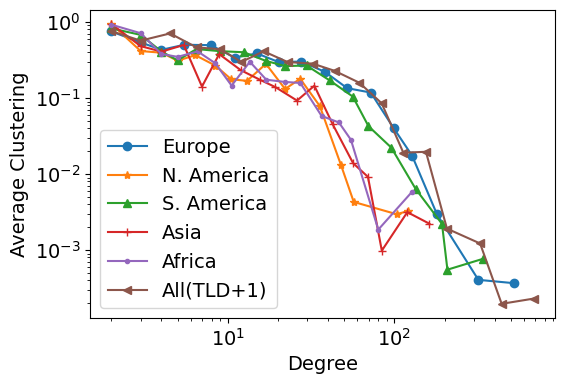

In [16]:
### Average clustering - PLOT ###
### Read the fortran output files and plot the results ###
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

pp = PdfPages(PLOTS_FOLDER + "ContinentAverageClustering.pdf")

plt.figure(figsize=(6, 4)) 
plt.xlabel('Degree')
plt.ylabel('Average Clustering')
plt.xscale("log")
plt.yscale("log")

sympols = ["o-", "*-", "^-", "+-", ".-", "<-"]

for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    cont_name = i.replace(". ", "-")
    in_file_name = OUT_FOLDER + "cont_{}_average_clustering.dat".format(cont_name)
    X = []
    Y = []
    with open(in_file_name, "r") as fp:
        for l in fp.readlines():
            tmp = l.strip().replace("D", "E").split(" ")
            X.append(float(tmp[0]))
            Y.append(float(tmp[1]))
    plt.plot(X, Y, sympols[c], label=i)

### TLD+1 ###
in_file_name = OUT_FOLDER + "cont_{}_average_clustering.dat".format("TLD+1")
X = []
Y = []
with open(in_file_name, "r") as fp:
    for l in fp.readlines():
        tmp = l.strip().replace("D", "E").split(" ")
        X.append(float(tmp[0]))
        Y.append(float(tmp[1]))
plt.plot(X, Y, sympols[c+1], label="All(TLD+1)")

plt.legend()
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

In [17]:
### Average neighbor degree ###
for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    tmp = []
    for p in perContinentPairs[i]:
        tmp.append(p.split("<->"))
    NETS[i] = nx.from_edgelist(tmp)
    dd = {}
    for k, v in NETS[i].degree():
        dd[k] = v
    dd_sorted = sorted(dd.items(), key=lambda item: item[1])

    avgSets = {}
    d = nx.average_neighbor_degree(NETS[i])
    for e in dd_sorted:
        k = e[0]
        v = e[1]
        if v not in avgSets:
            avgSets[v] = []
        avgSets[v].append(d[k])

    keys = []
    values = []
    for k in avgSets:
        keys.append(k)
        values.append(sum(avgSets[k])/len(avgSets[k]))
    
    lines = []
    for x, y in zip(keys, values):
        lines.append("{} {}".format(x, y))
    fi = i.replace(". ", "-")
    with open(OUT_FOLDER + "cont_{}_average_neighbor.txt".format(fi), "w") as fp:
        fp.write("\n".join(lines))

### ALL ###
for p in pairs_found:
    tmp.append(p.split("<->"))

ALL_P = nx.from_edgelist(tmp)

dd = {}
for k, v in ALL_P.degree():
    dd[k] = v

dd_sorted = sorted(dd.items(), key=lambda item: item[1])

avgSets = {}
d = nx.average_neighbor_degree(ALL_P)

for e in dd_sorted:
    k = e[0]
    v = e[1]
    if v not in avgSets:
        avgSets[v] = []
    avgSets[v].append(d[k])

keys = []
values = []
for k in avgSets:
    keys.append(k)
    values.append(sum(avgSets[k])/len(avgSets[k]))

lines = []
for x, y in zip(keys, values):
    lines.append("{} {}".format(x, y))
with open(OUT_FOLDER + "cont_{}_average_neighbor.txt".format("TLD+1"), "w") as fp:
    fp.write("\n".join(lines))

In [18]:
# Create the file names of the output of the previous cell and generate the binning data using the .\P_k_binned.exe executable file
tmp = edgeLists.keys()
f_names = [x.replace(". ", "-") for x in tmp]
f_names.append("TLD+1")

init_val = 1.0
steps = 20

for f in f_names:
    input_file = OUT_FOLDER + "cont_{}_average_neighbor.txt".format(f)
    output_file = input_file.replace(".txt", ".dat")
    print(input_file)
    print(output_file)
    cmd = ".\P_k_binned.exe {} {} {} {}".format(input_file, output_file, init_val, steps)
    !{cmd}

TMP_FOLDER/cont_Europe_average_neighbor.txt
TMP_FOLDER/cont_Europe_average_neighbor.dat
 input_file:TMP_FOLDER/cont_Europe_average_neighbor.txt
 output_file:TMP_FOLDER/cont_Europe_average_neighbor.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         564
TMP_FOLDER/cont_N-America_average_neighbor.txt
TMP_FOLDER/cont_N-America_average_neighbor.dat
 input_file:TMP_FOLDER/cont_N-America_average_neighbor.txt
 output_file:TMP_FOLDER/cont_N-America_average_neighbor.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         137
TMP_FOLDER/cont_S-America_average_neighbor.txt
TMP_FOLDER/cont_S-America_average_neighbor.dat
 input_file:TMP_FOLDER/cont_S-America_average_neighbor.txt
 output_file:TMP_FOLDER/cont_S-America_average_neighbor.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         365
TMP_FOLDER/cont_Asia_average_neighbor.txt
TMP_FOLDER/cont_Asia_average_neighbor.dat
 input_file:TMP_FOLDER/cont_Asia_average_neighbor.txt
 output_file:TMP

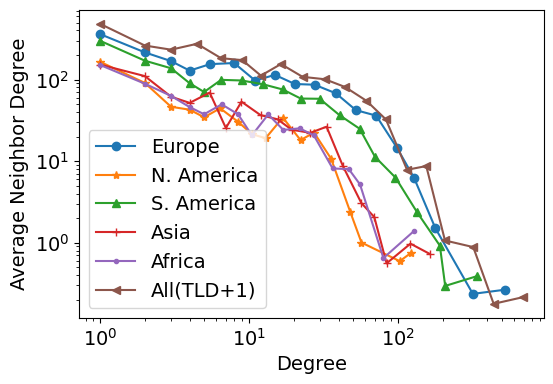

In [19]:
### Average neighbor degree - PLOT ###
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

pp = PdfPages(PLOTS_FOLDER + "ContinentAverageNeighborDegree.pdf")

plt.figure(figsize=(6, 4)) 
plt.xlabel('Degree')
plt.ylabel('Average Neighbor Degree')
plt.xscale("log")
plt.yscale("log")

sympols = ["o-", "*-", "^-", "+-", ".-", "<-"]

for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    cont_name = i.replace(". ", "-")
    in_file_name = OUT_FOLDER + "cont_{}_average_neighbor.dat".format(cont_name)
    X = []
    Y = []
    with open(in_file_name, "r") as fp:
        for l in fp.readlines():
            tmp = l.strip().replace("D", "E").split(" ")
            X.append(float(tmp[0]))
            Y.append(float(tmp[1]))
    plt.plot(X, Y, sympols[c], label=i)

### TLD+1 ###
in_file_name = OUT_FOLDER + "cont_{}_average_neighbor.dat".format("TLD+1")
X = []
Y = []
with open(in_file_name, "r") as fp:
    for l in fp.readlines():
        tmp = l.strip().replace("D", "E").split(" ")
        X.append(float(tmp[0]))
        Y.append(float(tmp[1]))
plt.plot(X, Y, sympols[c+1], label="All(TLD+1)")

plt.legend()
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

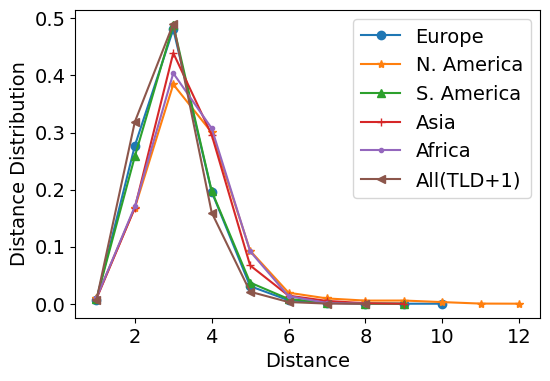

In [20]:
### Distance distribution ###
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

pp = PdfPages(PLOTS_FOLDER + "ContinentDistanceDistribution.pdf")

plt.figure(figsize=(6, 4)) 
plt.xlabel('Distance')
plt.ylabel('Distance Distribution')

sympols = ["o-", "*-", "^-", "+-", ".-", "<-"]

for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    tmp = []
    for p in perContinentPairs[i]:
        tmp.append(p.split("<->"))

    NETS[i] = nx.from_edgelist(tmp)
    nodes_num = NETS[i].number_of_nodes()
    all_links = nodes_num*(nodes_num-1)
    length = dict(nx.all_pairs_shortest_path_length(NETS[i]))
    
    FF = {}
    for e in length:
        for j in length[e]:
            if length[e][j] not in FF:
                FF[length[e][j]] = 0
            FF[length[e][j]] += 1 
    keys = []
    values = []
    for f in FF:
        if f == 0:
            continue
        tmp = FF[f] / sum(FF.values())
        keys.append(f)
        values.append(tmp)
    plt.plot(keys, values, sympols[c], label=i)

#ALL
tmp = []
for p in pairs_found:
    tmp.append(p.split("<->"))

ALL_P = nx.from_edgelist(tmp)
nodes_num = ALL_P.number_of_nodes()
all_links = nodes_num*(nodes_num-1)

length = dict(nx.all_pairs_shortest_path_length(ALL_P))

FF = {}
for e in length:
    for j in length[e]:
        if length[e][j] not in FF:
            FF[length[e][j]] = 0
        FF[length[e][j]] += 1 

keys = []
values = []
for f in FF:
    if f == 0:
        continue
    tmp = FF[f] / sum(FF.values())
    keys.append(f)
    values.append(tmp)
plt.plot(keys, values, sympols[c+1], label="All(TLD+1)")

plt.legend()
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

In [21]:
### Betweenness ###
for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    tmp = []
    for p in perContinentPairs[i]:
        tmp.append(p.split("<->"))
    NETS[i] = nx.from_edgelist(tmp)
    dd = {}
    for k, v in NETS[i].degree():
        dd[k] = v
    dd_sorted = sorted(dd.items(), key=lambda item: item[1])

    avgSets = {}
    BB = nx.betweenness_centrality(NETS[i], normalized = True, endpoints = False)
    for e in dd_sorted:
        k = e[0]
        v = e[1]
        if v not in avgSets:
            avgSets[v] = []
        avgSets[v].append(BB[k])
    
    keys = []
    values = []
    for k in avgSets:
        tmp = sum(avgSets[k])/len(avgSets[k])
        values.append(tmp)
        keys.append(k)
    
    lines = []
    for x, y in zip(keys, values):
        lines.append("{} {}".format(x, y))
    i = i.replace(". ", "-")
    with open(OUT_FOLDER + "cont_{}_betweenness.txt".format(i), "w") as fp:
        fp.write("\n".join(lines))

### ALL ###
tmp = []
for p in pairs_found:
    tmp.append(p.split("<->"))
ALL_P = nx.from_edgelist(tmp)
dd = {}
for k, v in ALL_P.degree():
    dd[k] = v
dd_sorted = sorted(dd.items(), key=lambda item: item[1])

avgSets = {}
BB = nx.betweenness_centrality(ALL_P, normalized = True, endpoints = False)
for e in dd_sorted:
    k = e[0]
    v = e[1]
    if v not in avgSets:
        avgSets[v] = []
    avgSets[v].append(BB[k])

keys = []
values = []
for k in avgSets:
    tmp = sum(avgSets[k])/len(avgSets[k])
    values.append(tmp)
    keys.append(k)
lines = []
for x, y in zip(keys, values):
    lines.append("{} {}".format(x, y))
with open(OUT_FOLDER + "cont_{}_betweenness.txt".format("TLD+1"), "w") as fp:
    fp.write("\n".join(lines))

In [22]:
# Create the file names of the output of the previous cell and generate the binning data using the .\P_k_binned.exe executable file
tmp = edgeLists.keys()
f_names = [x.replace(". ", "-") for x in tmp]
f_names.append("TLD+1")

init_val = 1.0
steps = 20

for f in f_names:
    input_file = OUT_FOLDER + "cont_{}_betweenness.txt".format(f)
    output_file = input_file.replace(".txt", ".dat")
    print(input_file)
    print(output_file)
    cmd = ".\P_k_binned.exe {} {} {} {}".format(input_file, output_file, init_val, steps)
    !{cmd}

TMP_FOLDER/cont_Europe_betweenness.txt
TMP_FOLDER/cont_Europe_betweenness.dat
 input_file:TMP_FOLDER/cont_Europe_betweenness.txt
 output_file:TMP_FOLDER/cont_Europe_betweenness.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         564
TMP_FOLDER/cont_N-America_betweenness.txt
TMP_FOLDER/cont_N-America_betweenness.dat
 input_file:TMP_FOLDER/cont_N-America_betweenness.txt
 output_file:TMP_FOLDER/cont_N-America_betweenness.datTMP_FOLDER/cont_S-America_betweenness.txt
 qini:   1.0000000000000000     
 numeropuntos:          20
         137

TMP_FOLDER/cont_S-America_betweenness.dat
 input_file:TMP_FOLDER/cont_S-America_betweenness.txt
 output_file:TMP_FOLDER/cont_S-America_betweenness.dat
 qini:   1.0000000000000000     
 numeropuntos:          20
         365
TMP_FOLDER/cont_Asia_betweenness.txt
TMP_FOLDER/cont_Asia_betweenness.dat
 input_file:TMP_FOLDER/cont_Asia_betweenness.txt
 output_file:TMP_FOLDER/cont_Asia_betweenness.dat
 qini:   1.0000000000000000     
 numerop

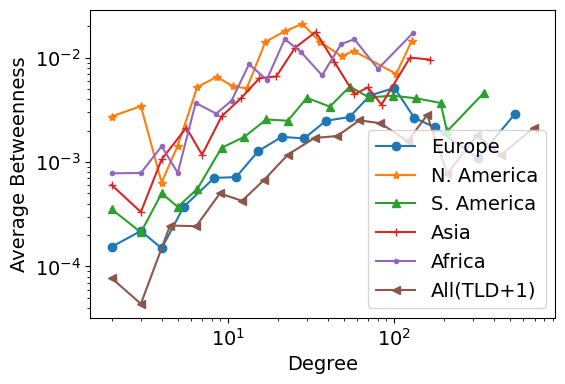

In [23]:
### Betweenness - PLOT ###
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

pp = PdfPages(PLOTS_FOLDER + "ContinentBetweenness.pdf")

plt.figure(figsize=(6, 4)) 
plt.xlabel('Degree')
plt.ylabel('Average Betweenness')
plt.xscale("log")
plt.yscale("log")

sympols = ["o-", "*-", "^-", "+-", ".-", "<-"]

for c, i in zip(range(len(perContinentPairs)), perContinentPairs):
    cont_name = i.replace(". ", "-")
    in_file_name = OUT_FOLDER + "cont_{}_betweenness.dat".format(cont_name)
    X = []
    Y = []
    with open(in_file_name, "r") as fp:
        for l in fp.readlines():
            tmp = l.strip().replace("D", "E").split(" ")
            X.append(float(tmp[0]))
            Y.append(float(tmp[1]))
    plt.plot(X, Y, sympols[c], label=i)

### TLD+1 ###
in_file_name = OUT_FOLDER + "cont_{}_betweenness.dat".format("TLD+1")
X = []
Y = []
with open(in_file_name, "r") as fp:
    for l in fp.readlines():
        tmp = l.strip().replace("D", "E").split(" ")
        X.append(float(tmp[0]))
        Y.append(float(tmp[1]))
plt.plot(X, Y, sympols[c+1], label="All(TLD+1)")

plt.legend()
plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()